In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.metrics import mean_squared_error
from jupyterthemes import jtplot
jtplot.style()

In [2]:
def generateSpins(N):
    return np.random.choice([-1,1],size=N)

def generateS(J):
    return np.where(J==0,J,1)

def getEnergy(s, J):
    ss = (np.dot(S,s) + np.dot(s,S))*s
    E = -J@np.sum(ss)
    return E

def getDeltaE(i, s, J):
    q = 2*np.dot(s,J[i])
    return s[i]*q


def update(s, N, J, beta):
    i = np.random.choice(N)
    deltaE = getDeltaE(i, s, J)
    if deltaE < 0:
        s[i] *= -1
    elif np.random.random() < np.exp(-beta*deltaE):
        s[i] *= -1
    return s

In [3]:
''' a matrix of random uniform connections J[ij], where 
    J[ij] = 0  w.p. 0.4
    J[ij] = random.uniform() w.p. 0.6
    J[ii] = 0
'''
N = 6
J = np.zeros((N,N))
for i in range (N):   
    for j in range(i,N):        
        J[i][j] = J[j][i] = np.random.choice([0,np.random.uniform(0,0.4)],p=[0.4,0.6])
        J[i][i] = 0
np.around(J,decimals = 3)

array([[0.   , 0.13 , 0.276, 0.   , 0.   , 0.   ],
       [0.13 , 0.   , 0.178, 0.364, 0.   , 0.374],
       [0.276, 0.178, 0.   , 0.327, 0.   , 0.   ],
       [0.   , 0.364, 0.327, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.374, 0.   , 0.   , 0.   , 0.   ]])

In [4]:
''' Run the ising model with random initial states for many steps
M times with the same J matrix and store the configurations in a df
'''

beta = 2
S = generateS(J)
iterations = 1000
M = 300 # configs
configs = []
for i in range(M):
    lattice = generateSpins(N)

    for n in range(iterations):
        lattice = update(lattice, N, J, beta)
    configs.append(lattice)

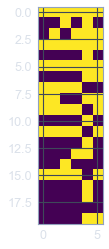

In [5]:
plt.imshow(configs[0:20])
plt.show()

In [6]:
df = pd.DataFrame(configs)

In [7]:
''' Convert df to numpy'''
df = pd.DataFrame(df).to_numpy()

In [8]:
''' Compute the obsereved correlation matrix C
C[ij] = (n-(M-n))/M = 2n/M -1, 
M is number of configurations and n is number of configs where s_i and s_j same

'''
def Corr(df,M):
    C = np.zeros((N,N))
    ct = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            same = 0
            i_samp = df[0:,i]
            j_samp = df[0:,j]
            for k in range(M):
                if i_samp[k] == j_samp[k]:
                    same +=1            
            c_ij = 2*same/M - 1
            C[i][j] = c_ij            
    return C
C = Corr(df,M)
np.around(C,decimals = 2)

array([[ 1.  ,  0.55,  0.69,  0.57, -0.01,  0.35],
       [ 0.55,  1.  ,  0.67,  0.78,  0.03,  0.63],
       [ 0.69,  0.67,  1.  ,  0.75, -0.05,  0.4 ],
       [ 0.57,  0.78,  0.75,  1.  , -0.01,  0.49],
       [-0.01,  0.03, -0.05, -0.01,  1.  ,  0.07],
       [ 0.35,  0.63,  0.4 ,  0.49,  0.07,  1.  ]])

In [9]:
np.around(np.corrcoef(df.T),2)

array([[ 1.  ,  0.55,  0.69,  0.57, -0.01,  0.35],
       [ 0.55,  1.  ,  0.67,  0.78,  0.03,  0.63],
       [ 0.69,  0.67,  1.  ,  0.75, -0.05,  0.4 ],
       [ 0.57,  0.78,  0.75,  1.  , -0.01,  0.49],
       [-0.01,  0.03, -0.05, -0.01,  1.  ,  0.07],
       [ 0.35,  0.63,  0.4 ,  0.49,  0.07,  1.  ]])

# Inverse Ising

at each step update $J_{ij}$ to $J_{ij}$ + $\Delta J_{ij}$, where
\begin{equation}
\Delta J_{ij} = \alpha (C_{ij0}-C_{ij}(t))
\end{equation}

and

\begin{equation}
C_{ij}(t) = (1-\epsilon)C_{ij}(t-1)+\epsilon C_{ij}(t)
\end{equation}


In [10]:
def inv_ising(C, guess_J,M, alpha,epsilon, tol = 0.05,beta = 2,steps = 200, max_steps = 1000):
    '''
    input:
    C = target corr matrix
    guess_J initial guess for J
    M number of ising configurations at each step
    alpha = gradient value
    epsilon = weight of prev observations
    steps = steps of the ising model
    
    '''
    eps = 1
    error =  []
    N = len(guess_J)
    s = 0
    while eps == 1:
        s+=1
        if s>max_steps:
            break
        else:
            # make configurations
            configs_train = [] 
            for i in range(M):
                lattice = generateSpins(N)

                for n in range(iterations):
                    lattice = update(lattice, N, guess_J, beta)
                configs_train.append(lattice)
             
            df_obs = pd.DataFrame(configs_train) 
            df_obs = pd.DataFrame(df_obs).to_numpy()  
            # calculate current C
            C_obs =Corr(df_obs,M)
            
            if s>1: 
                
                #C_obs = (1-epsilon)*C_prev + epsilon*(1/M)*np.sum(i_samp*j_samp)
                C_obs = (1-epsilon)*C_prev+epsilon*C_obs
                

                    
            delta =  C -C_obs
        
            if np.average(np.abs(delta)) <=tol:
                    eps = 0
                    print("converged")
            
            guess_J+=alpha*delta
            guess_J = guess_J.clip(min=0)
            error.append(np.average(np.abs(delta)))
            C_prev = C_obs
    return guess_J, C_obs,error

In [11]:
epsilon = 0.05
alpha = 5*10**(-3)

In [12]:
guess_J = np.copy(C)
guess_J = guess_J.clip(min=0)
np.around(guess_J,2)

array([[1.  , 0.55, 0.69, 0.57, 0.  , 0.35],
       [0.55, 1.  , 0.67, 0.78, 0.03, 0.63],
       [0.69, 0.67, 1.  , 0.75, 0.  , 0.4 ],
       [0.57, 0.78, 0.75, 1.  , 0.  , 0.49],
       [0.  , 0.03, 0.  , 0.  , 1.  , 0.07],
       [0.35, 0.63, 0.4 , 0.49, 0.07, 1.  ]])

In [13]:
# prints number of steps
J_est, C_est ,error= inv_ising(C, guess_J,M, alpha,epsilon,tol = 0.01,max_steps = 1000)

In [14]:
np.around(J_est-np.identity(N), decimals = 2)

array([[0.  , 0.06, 0.17, 0.  , 0.  , 0.01],
       [0.06, 0.  , 0.03, 0.23, 0.  , 0.18],
       [0.17, 0.03, 0.  , 0.2 , 0.  , 0.  ],
       [0.  , 0.23, 0.2 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.02],
       [0.01, 0.18, 0.  , 0.  , 0.02, 0.  ]])

In [15]:
np.around(J, decimals = 2)

array([[0.  , 0.13, 0.28, 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.18, 0.36, 0.  , 0.37],
       [0.28, 0.18, 0.  , 0.33, 0.  , 0.  ],
       [0.  , 0.36, 0.33, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.37, 0.  , 0.  , 0.  , 0.  ]])

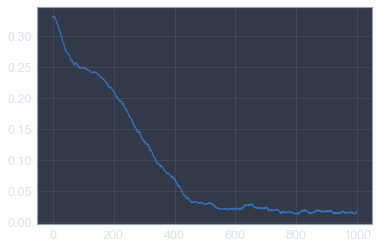

In [16]:

plt.plot(error)
plt.show()


In [17]:
J_est = J_est-np.identity(6)

In [29]:
mean_squared_error(J_est,J)

0.00619680040479505

In [19]:
mean_squared_error(C_est,C)

0.0006810149743570613

In [21]:
np.around(C,2),np.around(C_est,2)

(array([[ 1.  ,  0.55,  0.69,  0.57, -0.01,  0.35],
        [ 0.55,  1.  ,  0.67,  0.78,  0.03,  0.63],
        [ 0.69,  0.67,  1.  ,  0.75, -0.05,  0.4 ],
        [ 0.57,  0.78,  0.75,  1.  , -0.01,  0.49],
        [-0.01,  0.03, -0.05, -0.01,  1.  ,  0.07],
        [ 0.35,  0.63,  0.4 ,  0.49,  0.07,  1.  ]]),
 array([[1.  , 0.55, 0.68, 0.58, 0.02, 0.35],
        [0.55, 1.  , 0.67, 0.79, 0.05, 0.62],
        [0.68, 0.67, 1.  , 0.79, 0.03, 0.43],
        [0.58, 0.79, 0.79, 1.  , 0.04, 0.49],
        [0.02, 0.05, 0.03, 0.04, 1.  , 0.09],
        [0.35, 0.62, 0.43, 0.49, 0.09, 1.  ]]))

--------------------------------------------
# Plot network


In [22]:
labels =  list(range(N))

G = nx.from_numpy_matrix(J)

G = nx.relabel_nodes(G,lambda x: labels[x])

G.edges(data=True)


EdgeDataView([(0, 1, {'weight': 0.12976854645242045}), (0, 2, {'weight': 0.27608408083539926}), (1, 2, {'weight': 0.17767020578858297}), (1, 3, {'weight': 0.3643441571750978}), (1, 5, {'weight': 0.3742536162659252}), (2, 3, {'weight': 0.3268848710151149})])

In [23]:
def plot_network(connections):
    labels =  list(range(len(connections)))
    G = nx.from_numpy_matrix(connections)
    G = nx.relabel_nodes(G,lambda x: labels[x])
    G.edges(data=True)

    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #positions
    positions=nx.circular_layout(G)    
    #Figure size
    plt.figure(figsize=(8,8))
    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#FEB335',
                           node_size=500)    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,width = 4, edge_color ='#0699e5')    
    # displays the graph without axis
    plt.axis('off')      
    plt.show() 

In [24]:
J_draw = np.where(J_est>0.1,J_est,0)

In [25]:
J_draw

array([[0.        , 0.        , 0.17402225, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.22571822, 0.        ,
        0.17939998],
       [0.17402225, 0.        , 0.        , 0.20068325, 0.        ,
        0.        ],
       [0.        , 0.22571822, 0.20068325, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.17939998, 0.        , 0.        , 0.        ,
        0.        ]])

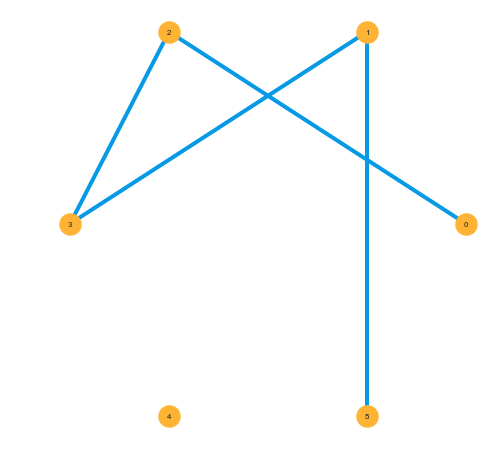

In [26]:
plot_network(J_draw)

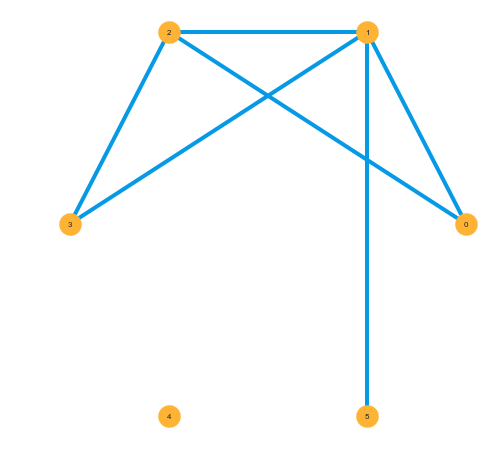

In [27]:
plot_network(J)